<a href="https://colab.research.google.com/github/ramkamal2000/DeepLearning.ai-Summary/blob/master/PartA_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Required Libraries

In [2]:
!pip install wandb
# !pip install tensorflow
# !pip install keras

     |████████████████████████████████| 2.1MB 21.5MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 133kB 45.6MB/s 
     |████████████████████████████████| 163kB 42.3MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=ff9f65fb310faf182a1505d79e96e77a4a1e8284ec3522e2eb3a06b5d66411f5
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=7aa7ea5ef355a4f1888e0b229d69ba31cccb5666a76453a13c6b6d76fa785e79
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import shutil
import pprint
import wandb
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!wget -nc https://storage.googleapis.com/wandb_datasets/nature_12K.zip
if not os.path.isdir('/content/inaturalist_12K'):
  ZipFile('/content/nature_12K.zip').extractall()

--2021-04-15 07:57:28--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  32.1MB/s    in 66s     

2021-04-15 07:58:34 (55.5 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
wandb.login(key='feaed71a1d227d1c2ec9d80e592582248a32f930', force=True)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
429 response executing GraphQL.
{"error":"rate limit exceeded"}

429 response executing GraphQL.
{"error":"rate limit exceeded"}



True

# Data Split

# Question 1

In [ ]:
train_val_dir = '/content/inaturalist_12K/train'
test_dir = '/content/inaturalist_12K/val'

In [ ]:
class dataset:
  @staticmethod
  def train_val_test_data_loader(train_val_dir, test_dir, val_split=0.2, seed=6910, image_size=(700, 700), batch_size=32):
    #train data
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_val_dir,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
        )
    #val data
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_val_dir,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
        )
    #test data
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        
        test_dir,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
        )

    print(train_ds.class_names)

    return {
        'train': train_ds, 
        'val': val_ds,
        'test': test_ds
    }

  @staticmethod
  def display_samples(ds, figsize=(10,10)):
    #display one sample for each class
    class_names = ds.class_names
    plt.figure(figsize=figsize)
    for images, labels in ds.take(1):
      for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Found 2000 files belonging to 10 classes.
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


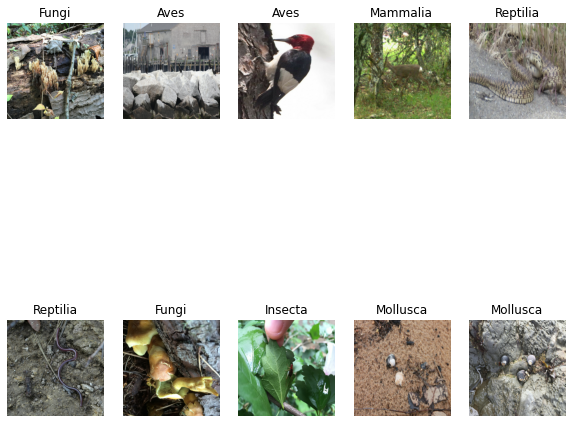

In [ ]:
data = dataset.train_val_test_data_loader(train_val_dir, test_dir)
dataset.display_samples(data['train'], (10, 10))

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

H, W = 700, 700

def load_image(path, preprocess=True):
    x = image.load_img(path, target_size=(H, W))
    plt.imshow(x)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    return x

def deprocess_image(x):
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

@tf.custom_gradient
def guidedRelu(x):
  # change the gradient
  # if gradient is negative, make it to zero
  def grad(dy):
    extra = tf.cast(dy>0,"float32")
    return  extra * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [ ]:
class cnn :
  def __init__(self, params):
    '''
        This function builds a cnn model based on the parameters passed
        Input : params - contains 
                      1. Image shape
                      2. number of layers
                      3. Filter size
                      4. Number of filters in each layer
                      5. activation function to be used
                      6. batchNorm - bool value
                      7. augmentation - bool value
                      8. droupout - The dropout to be used
    '''
    #get cnn parameters from params
    img_shape = params['img_shape']
    activation = params['activation']
    filter_size = params['filter_size']
    num_classes = params['num_classes']
    dropout = params['dropout']
    num_filters = params['num_filters']
    augmentation = params['augmentation']

    #Make all imputs between (0,1)
    model = Sequential(layers.experimental.preprocessing.Rescaling(1./255, input_shape=img_shape))
    
    # data augmentation
    if augmentation:
      model.add(layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'))
      model.add(layers.experimental.preprocessing.RandomRotation(0.1))
      model.add(layers.experimental.preprocessing.RandomTranslation(0.3,0.3))

    # dropout after the input layer
    model.add(layers.Dropout(dropout))

    for j in range(len(num_filters)) :
      #convolution layer, followed by activation, then batch_norm and finally max pooling
      if params['batch_norm'] :
        model.add(layers.Conv2D(num_filters[j] , filter_size, padding='same', use_bias=False))
        model.add(layers.Activation(activation))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D( pool_size=(2,2) ))
      else :
        model.add(layers.Conv2D(num_filters[j] , filter_size, padding='same'))
        model.add(layers.Activation(activation))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
      

    # dropout and flatten before the first dense layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(params['dense_layer_size'], activation=activation))

    # dropout before last output layer
    model.add(layers.Dropout(dropout))


    # output layer, with activation as softmax
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    self.model = model
    

  def compile_and_fit(self, data, params,logging=True) :
    '''
        This function compiles, prints summary of model and fits the data
        Input : data - dictionary with data['train'] and data['val']
                params - contains details number of epochs and optimizer to be used
        Returns : The run details
    '''
   
    # get train and validation data
    train_ds, val_ds = data['train'], data['val']

    # get epochs and optimizer
    optimizer, epochs = params['optimizer'], params['num_epochs']

    if optimizer == 'NAG' :
      optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

    #compile
    self.model.compile(optimizer=optimizer, 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy']
                       )
    
    # print summary
    summary = self.model.summary()

    # fit the data
    # if logging, include wandb's callback and earlystopping 
    if logging :
      run_details = self.model.fit(train_ds, 
                                 validation_data=val_ds, 
                                 epochs=epochs,
                                 callbacks=[
                                   wandb.keras.WandbCallback(save_model=False),
                                   keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                          patience=3, 
                                                                          restore_best_weights=True)]
                                 )
    else :
      run_details = self.model.fit(train_ds, 
                                 validation_data=val_ds, 
                                 epochs=epochs
                                 )

    return {
        'summary': summary,
        'run_details' : run_details
    }

  def guided_backprop(self,layername,inp_image,index) :
      '''
        This function implements guided backprop on given neurons in a given layer
        Inputs : layername
                inp_image : image in numpy array format
                index : To specify which neuron
      '''
      model = self.model
      if len(index)==0 :
        gb_model = Model(
            inputs = [model.inputs],
            outputs = [model.get_layer(layername).output]
        )
      elif len(index)==1 :
        gb_model = Model(
            inputs = [model.inputs],
            outputs = [model.get_layer(layername).output[:,:,:,index[0]]]
        )
      elif len(index)==2 :
        gb_model = Model(
            inputs = [model.inputs],
            outputs = [model.get_layer(layername).output[:,:,index[0],index[1]]]
        )
      elif len(index)==3 :
        gb_model = Model(
            inputs = [model.inputs],
            outputs = [model.get_layer(layername).output[:,index[0],index[1],index[2]]]
        )
      
      #replace relu with our guidedRelu
      layers = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
      for layer in layers:
        if layer.activation == tf.keras.activations.relu:
          layer.activation = guidedRelu

      #use tf.GradientTape for getting gradient
      with tf.GradientTape() as tape:
        inputs = tf.cast(inp_image, tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)

      #get the gradient.
      grads = tape.gradient(outputs,inputs)

      #grads shape is 1x(inputs_shape) 
      immage = np.flip(deprocess_image(np.array(grads[0])),-1)
      plt.imshow(immage)
      plt.axis("off");
      return immage

  def test_model(self,data) :
    ''' 
        This function evaluates the trained model.
        Input : test data
    '''
    self.model.evaluate(data)

In [ ]:
class cnn_tools:
  def init_params(config):
    
    # building num_layers array
    if config.type_of_filters == 'same' :
      num_filters = config.num_filters_*np.ones(config.num_layers)
      
    elif config.type_of_filters == 'double' :
      num_filters = config.num_filters_*np.ones(config.num_layers)
      for j in range(config.num_layers-1) :
        num_filters[j+1] = num_filters[j]*2
      
    elif config.type_of_filters == 'half' :
      num_filters = config.num_filters_*np.ones(config.num_layers)
      for j in range(config.num_layers-1) :
        num_filters[j+1] = num_filters[j]*2
      num_filters = num_filters[::-1]

    # typecasting num_filters
    num_filters = np.array(num_filters, dtype=np.int32)
    
    # returning parameters
    params = {
        'filter_size' : (config.filter_size, config.filter_size),
        'num_filters' : num_filters,
        'activation' : config.activation,
        'num_classes' : 10,
        'img_shape' : (700, 700, 3),
        'dropout' : config.dropout,
        'batch_norm' : config.batch_norm,
        'dense_layer_size' : config.dense_layer_size,
        'num_epochs' : config.num_epochs,
        'optimizer' : config.optimizer,
        'augmentation': config.augmentation
    }

    return params


# Question 2

In [ ]:
# sweep configuration
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters': {
        'num_filters_': {
            'values': [16, 32, 64]
        },
        'type_of_filters': {
            'values': ['same', 'half', 'double']
        },
        'augmentation': {
            'values': [True, False]
        },
        'batch_norm': {
            'values': [True, False]
        },
        'dense_layer_size': {
            'values': [128, 256, 512]
        },
        'dropout': {
            'values': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'NAG', 'RMSprop']
        },
        'batch_size': {
            'values': [8, 16, 32]
        },
        'num_epochs': {
            'values': [25]
        },
        'num_layers': {
            'values': [5]
        },
        'activation': {
            'values': ['tanh', 'relu']
        },
        'filter_size' : {
            'values': [3, 5]
        }        
    }
}

In [ ]:
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['tanh', 'relu']},
                'augmentation': {'values': [True, False]},
                'batch_norm': {'values': [True, False]},
                'batch_size': {'values': [8, 16, 32]},
                'dense_layer_size': {'values': [128, 256, 512]},
                'dropout': {'values': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
                'filter_size': {'values': [3, 5]},
                'num_epochs': {'values': [25]},
                'num_filters_': {'values': [16, 32, 64]},
                'num_layers': {'values': [5]},
                'optimizer': {'values': ['adam', 'nadam', 'NAG', 'RMSprop']},
                'type_of_filters': {'values': ['same', 'half', 'double']}}}


In [ ]:
class sweep_module:
  @staticmethod
  def train(config=None):

    with wandb.init(config):
      
      config = wandb.config
 
      wandb.run.name = 'fil:'+str(config['num_filters_'])+'_type:'+config['type_of_filters'][0]+'_aug:'+str(config['augmentation'])[0]+'_dro:'+str(config['dropout'])[0]
      params = cnn_tools.init_params(config)
      network = cnn(params)
      data = dataset.train_val_test_data_loader(train_val_dir, test_dir, batch_size=config.batch_size)
      run_det = network.compile_and_fit(data, params)


In [ ]:
sweep_id = wandb.sweep(sweep_config, project='inaturalist_partA_15.1')

Create sweep with ID: 2c92rrma
Sweep URL: https://wandb.ai/ee18b153/inaturalist_partA_15.1/sweeps/2c92rrma


In [ ]:
sweep_id = 'hz3tmq0n'

In [ ]:
# performing the sweep
wandb.agent(sweep_id, sweep_module.train)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fa2zzbk6 with config:
wandb: 	activation: tanh
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_layer_size: 128
wandb: 	dropout: 0.5
wandb: 	filter_size: 5
wandb: 	num_epochs: 25
wandb: 	num_filters_: 64
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	type_of_filters: half
429 response executing GraphQL.
{"error":"rate limit exceeded"}

wandb: Currently logged in as: ee18b153 (use `wandb login --relogin` to force relogin)


Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Found 2000 files belonging to 10 classes.
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 700, 700, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 700, 700, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 700, 700, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 700, 700, 3)       0         
_________________________________________________________________
dropout (Dropout)

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080046-fa2zzbk6/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.056695, resuming normal operation.


429 response executing GraphQL.
{"error":"rate limit exceeded"}

429 response executing GraphQL.
{"error":"rate limit exceeded"}

429 response executing GraphQL.
{"error":"rate limit exceeded"}

Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/old/retry.py", line 96, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 130, in execute
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.7/dist-packages/six.py", line 703, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 124, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.

Run fa2zzbk6 errored: ResourceExhaustedError()
wandb: ERROR Run fa2zzbk6 errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: of81sojs with config:
wandb: 	activation: tanh
wandb: 	augmentation: False
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_layer_size: 512
wandb: 	dropout: 0.1
wandb: 	filter_size: 5
wandb: 	num_epochs: 25
wandb: 	num_filters_: 32
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	type_of_filters: same
429 response executing GraphQL.
{"error":"rate limit exceeded"}



Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Found 2000 files belonging to 10 classes.
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 700, 700, 3)       0         
_________________________________________________________________
dropout (Dropout)            (None, 700, 700, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 700, 700, 32)      2400      
_________________________________________________________________
activation (Activation)      (None, 700, 700, 32)      0         
_________________________________________________________________
batch_normalizati

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


  3/250 [..............................] - ETA: 6:49 - loss: 3.9126 - accuracy: 0.1424

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 12/250 [>.............................] - ETA: 5:58 - loss: 4.7156 - accuracy: 0.1551

wandb: Network error resolved after 0:00:17.423632, resuming normal operation.


 25/250 [==>...........................] - ETA: 5:34 - loss: 4.3692 - accuracy: 0.1550

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 33/250 [==>...........................] - ETA: 5:21 - loss: 4.1916 - accuracy: 0.1547

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 54/250 [=====>........................] - ETA: 4:49 - loss: 3.8420 - accuracy: 0.1510

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 58/250 [=====>........................] - ETA: 4:43 - loss: 3.7925 - accuracy: 0.1501

wandb: Network error resolved after 0:00:08.919278, resuming normal operation.


 67/250 [=======>......................] - ETA: 4:30 - loss: 3.6949 - accuracy: 0.1483

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 76/250 [========>.....................] - ETA: 4:17 - loss: 3.6127 - accuracy: 0.1472

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 86/250 [=========>....................] - ETA: 4:02 - loss: 3.5357 - accuracy: 0.1466

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 95/250 [==========>...................] - ETA: 3:48 - loss: 3.4761 - accuracy: 0.1462

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


106/250 [===========>..................] - ETA: 3:32 - loss: 3.4126 - accuracy: 0.1458

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


109/250 [============>.................] - ETA: 3:28 - loss: 3.3969 - accuracy: 0.1457

wandb: Network error resolved after 0:00:08.923765, resuming normal operation.


117/250 [=============>................] - ETA: 3:16 - loss: 3.3578 - accuracy: 0.1456

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


128/250 [==============>...............] - ETA: 2:59 - loss: 3.3093 - accuracy: 0.1458

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


138/250 [===============>..............] - ETA: 2:45 - loss: 3.2702 - accuracy: 0.1460

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


156/250 [=================>............] - ETA: 2:18 - loss: 3.2102 - accuracy: 0.1460

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


159/250 [==================>...........] - ETA: 2:14 - loss: 3.2013 - accuracy: 0.1460

wandb: Network error resolved after 0:00:08.862500, resuming normal operation.


169/250 [===================>..........] - ETA: 1:59 - loss: 3.1732 - accuracy: 0.1459

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


178/250 [====================>.........] - ETA: 1:46 - loss: 3.1500 - accuracy: 0.1457

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


186/250 [=====================>........] - ETA: 1:34 - loss: 3.1307 - accuracy: 0.1456

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


196/250 [======================>.......] - ETA: 1:19 - loss: 3.1084 - accuracy: 0.1455

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


205/250 [=======================>......] - ETA: 1:06 - loss: 3.0896 - accuracy: 0.1454

wandb: Network error resolved after 0:00:17.334007, resuming normal operation.


216/250 [========================>.....] - ETA: 50s - loss: 3.0684 - accuracy: 0.1453

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


227/250 [==========================>...] - ETA: 34s - loss: 3.0488 - accuracy: 0.1453

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


248/250 [============================>.] - ETA: 2s - loss: 3.0149 - accuracy: 0.1452

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - ETA: 0s - loss: 3.0119 - accuracy: 0.1453

wandb: Network error resolved after 0:00:18.639009, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - 464s 2s/step - loss: 3.0104 - accuracy: 0.1453 - val_loss: 2.5752 - val_accuracy: 0.1476
Epoch 2/25


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 13/250 [>.............................] - ETA: 5:43 - loss: 2.4995 - accuracy: 0.1509

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 16/250 [>.............................] - ETA: 5:39 - loss: 2.4890 - accuracy: 0.1528

wandb: Network error resolved after 0:00:08.265611, resuming normal operation.


 22/250 [=>............................] - ETA: 5:32 - loss: 2.4797 - accuracy: 0.1544

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 33/250 [==>...........................] - ETA: 5:16 - loss: 2.4630 - accuracy: 0.1565

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 42/250 [====>.........................] - ETA: 5:03 - loss: 2.4557 - accuracy: 0.1577

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 51/250 [=====>........................] - ETA: 4:49 - loss: 2.4502 - accuracy: 0.1592

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 59/250 [======>.......................] - ETA: 4:38 - loss: 2.4473 - accuracy: 0.1600

wandb: Network error resolved after 0:00:16.210157, resuming normal operation.


 72/250 [=======>......................] - ETA: 4:19 - loss: 2.4423 - accuracy: 0.1614

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 84/250 [=========>....................] - ETA: 4:01 - loss: 2.4392 - accuracy: 0.1623

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 95/250 [==========>...................] - ETA: 3:45 - loss: 2.4370 - accuracy: 0.1632

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


106/250 [===========>..................] - ETA: 3:29 - loss: 2.4347 - accuracy: 0.1642

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


109/250 [============>.................] - ETA: 3:24 - loss: 2.4342 - accuracy: 0.1644

wandb: Network error resolved after 0:00:08.620092, resuming normal operation.


116/250 [============>.................] - ETA: 3:14 - loss: 2.4327 - accuracy: 0.1649

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


126/250 [==============>...............] - ETA: 2:59 - loss: 2.4302 - accuracy: 0.1655

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


135/250 [===============>..............] - ETA: 2:46 - loss: 2.4285 - accuracy: 0.1659

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


146/250 [================>.............] - ETA: 2:30 - loss: 2.4264 - accuracy: 0.1664

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


155/250 [=================>............] - ETA: 2:17 - loss: 2.4249 - accuracy: 0.1668

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


164/250 [==================>...........] - ETA: 2:04 - loss: 2.4235 - accuracy: 0.1671

wandb: Network error resolved after 0:00:16.860009, resuming normal operation.


177/250 [====================>.........] - ETA: 1:45 - loss: 2.4216 - accuracy: 0.1674

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


188/250 [=====================>........] - ETA: 1:29 - loss: 2.4202 - accuracy: 0.1676

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


199/250 [======================>.......] - ETA: 1:13 - loss: 2.4192 - accuracy: 0.1677

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


210/250 [========================>.....] - ETA: 57s - loss: 2.4183 - accuracy: 0.1678

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


214/250 [========================>.....] - ETA: 51s - loss: 2.4181 - accuracy: 0.1678

wandb: Network error resolved after 0:00:09.029088, resuming normal operation.


232/250 [==========================>...] - ETA: 25s - loss: 2.4172 - accuracy: 0.1678

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


241/250 [===========================>..] - ETA: 12s - loss: 2.4168 - accuracy: 0.1678

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - ETA: 0s - loss: 2.4165 - accuracy: 0.1678

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.330601, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - 408s 2s/step - loss: 2.4165 - accuracy: 0.1678 - val_loss: 2.6238 - val_accuracy: 0.1051
Epoch 3/25


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 10/250 [>.............................] - ETA: 5:43 - loss: 2.3787 - accuracy: 0.1879

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 19/250 [=>............................] - ETA: 5:29 - loss: 2.3588 - accuracy: 0.1935

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 29/250 [==>...........................] - ETA: 5:14 - loss: 2.3605 - accuracy: 0.1886

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 32/250 [==>...........................] - ETA: 5:10 - loss: 2.3616 - accuracy: 0.1873

wandb: Network error resolved after 0:00:09.094965, resuming normal operation.


 50/250 [=====>........................] - ETA: 4:44 - loss: 2.3657 - accuracy: 0.1805

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 71/250 [=======>......................] - ETA: 4:15 - loss: 2.3679 - accuracy: 0.1774

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 75/250 [========>.....................] - ETA: 4:09 - loss: 2.3682 - accuracy: 0.1768

wandb: Network error resolved after 0:00:08.888320, resuming normal operation.


 92/250 [==========>...................] - ETA: 3:45 - loss: 2.3691 - accuracy: 0.1742

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


113/250 [============>.................] - ETA: 3:15 - loss: 2.3680 - accuracy: 0.1718

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


123/250 [=============>................] - ETA: 3:00 - loss: 2.3670 - accuracy: 0.1710

wandb: Network error resolved after 0:00:17.888226, resuming normal operation.


137/250 [===============>..............] - ETA: 2:41 - loss: 2.3655 - accuracy: 0.1703

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


148/250 [================>.............] - ETA: 2:25 - loss: 2.3646 - accuracy: 0.1698

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


157/250 [=================>............] - ETA: 2:12 - loss: 2.3636 - accuracy: 0.1694

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


166/250 [==================>...........] - ETA: 1:59 - loss: 2.3625 - accuracy: 0.1692

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


170/250 [===================>..........] - ETA: 1:53 - loss: 2.3620 - accuracy: 0.1691

wandb: Network error resolved after 0:00:09.257335, resuming normal operation.


176/250 [====================>.........] - ETA: 1:45 - loss: 2.3613 - accuracy: 0.1690

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


197/250 [======================>.......] - ETA: 1:15 - loss: 2.3590 - accuracy: 0.1686

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


210/250 [========================>.....] - ETA: 57s - loss: 2.3577 - accuracy: 0.1683

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


213/250 [========================>.....] - ETA: 52s - loss: 2.3575 - accuracy: 0.1683

wandb: Network error resolved after 0:00:08.991959, resuming normal operation.


220/250 [=========================>....] - ETA: 42s - loss: 2.3569 - accuracy: 0.1682

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


230/250 [==========================>...] - ETA: 28s - loss: 2.3561 - accuracy: 0.1680

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


240/250 [===========================>..] - ETA: 14s - loss: 2.3555 - accuracy: 0.1678

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - ETA: 0s - loss: 2.3548 - accuracy: 0.1677

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:18.415615, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - 405s 2s/step - loss: 2.3548 - accuracy: 0.1676 - val_loss: 2.3055 - val_accuracy: 0.1656
Epoch 4/25


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 11/250 [>.............................] - ETA: 5:38 - loss: 2.2537 - accuracy: 0.1898

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 22/250 [=>............................] - ETA: 5:23 - loss: 2.2691 - accuracy: 0.1867

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 25/250 [==>...........................] - ETA: 5:19 - loss: 2.2741 - accuracy: 0.1865

wandb: Network error resolved after 0:00:08.210226, resuming normal operation.


 31/250 [==>...........................] - ETA: 5:11 - loss: 2.2802 - accuracy: 0.1867

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 40/250 [===>..........................] - ETA: 4:58 - loss: 2.2837 - accuracy: 0.1876

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 50/250 [=====>........................] - ETA: 4:43 - loss: 2.2851 - accuracy: 0.1883

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 73/250 [=======>......................] - ETA: 4:11 - loss: 2.2877 - accuracy: 0.1905

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 77/250 [========>.....................] - ETA: 4:05 - loss: 2.2879 - accuracy: 0.1906

wandb: Network error resolved after 0:00:08.785498, resuming normal operation.


 84/250 [=========>....................] - ETA: 3:55 - loss: 2.2883 - accuracy: 0.1907

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 94/250 [==========>...................] - ETA: 3:41 - loss: 2.2888 - accuracy: 0.1909

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


103/250 [===========>..................] - ETA: 3:28 - loss: 2.2894 - accuracy: 0.1910

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


125/250 [==============>...............] - ETA: 2:57 - loss: 2.2897 - accuracy: 0.1912

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


128/250 [==============>...............] - ETA: 2:53 - loss: 2.2898 - accuracy: 0.1911

wandb: Network error resolved after 0:00:08.721841, resuming normal operation.


135/250 [===============>..............] - ETA: 2:43 - loss: 2.2899 - accuracy: 0.1911

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


156/250 [=================>............] - ETA: 2:13 - loss: 2.2897 - accuracy: 0.1914

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


177/250 [====================>.........] - ETA: 1:43 - loss: 2.2891 - accuracy: 0.1915

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


187/250 [=====================>........] - ETA: 1:29 - loss: 2.2889 - accuracy: 0.1915

wandb: Network error resolved after 0:00:19.439870, resuming normal operation.


198/250 [======================>.......] - ETA: 1:13 - loss: 2.2891 - accuracy: 0.1914

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


211/250 [========================>.....] - ETA: 55s - loss: 2.2902 - accuracy: 0.1910

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


221/250 [=========================>....] - ETA: 41s - loss: 2.2912 - accuracy: 0.1906

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


231/250 [==========================>...] - ETA: 26s - loss: 2.2924 - accuracy: 0.1902

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


234/250 [===========================>..] - ETA: 22s - loss: 2.2928 - accuracy: 0.1900

wandb: Network error resolved after 0:00:08.404915, resuming normal operation.


240/250 [===========================>..] - ETA: 14s - loss: 2.2936 - accuracy: 0.1897

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - ETA: 0s - loss: 2.2950 - accuracy: 0.1892

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.790531, resuming normal operation.


250/250 [==============================] - 404s 2s/step - loss: 2.2952 - accuracy: 0.1891 - val_loss: 2.3969 - val_accuracy: 0.1101
Epoch 5/25


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 20/250 [=>............................] - ETA: 5:24 - loss: 2.3807 - accuracy: 0.1521

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 33/250 [==>...........................] - ETA: 5:06 - loss: 2.3858 - accuracy: 0.1463

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 37/250 [===>..........................] - ETA: 5:00 - loss: 2.3873 - accuracy: 0.1449

wandb: Network error resolved after 0:00:08.776263, resuming normal operation.


 43/250 [====>.........................] - ETA: 4:51 - loss: 2.3891 - accuracy: 0.1432

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 53/250 [=====>........................] - ETA: 4:37 - loss: 2.3908 - accuracy: 0.1414

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 62/250 [======>.......................] - ETA: 4:25 - loss: 2.3917 - accuracy: 0.1410

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 84/250 [=========>....................] - ETA: 3:53 - loss: 2.3932 - accuracy: 0.1400

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 87/250 [=========>....................] - ETA: 3:49 - loss: 2.3933 - accuracy: 0.1399

wandb: Network error resolved after 0:00:09.074058, resuming normal operation.


105/250 [===========>..................] - ETA: 3:24 - loss: 2.3924 - accuracy: 0.1397

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


119/250 [=============>................] - ETA: 3:04 - loss: 2.3911 - accuracy: 0.1396

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


138/250 [===============>..............] - ETA: 2:37 - loss: 2.3889 - accuracy: 0.1397

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


142/250 [================>.............] - ETA: 2:32 - loss: 2.3884 - accuracy: 0.1398

wandb: Network error resolved after 0:00:09.069149, resuming normal operation.


151/250 [=================>............] - ETA: 2:19 - loss: 2.3873 - accuracy: 0.1400

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


171/250 [===================>..........] - ETA: 1:51 - loss: 2.3848 - accuracy: 0.1407

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


181/250 [====================>.........] - ETA: 1:37 - loss: 2.3836 - accuracy: 0.1411

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


190/250 [=====================>........] - ETA: 1:24 - loss: 2.3826 - accuracy: 0.1415

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


201/250 [=======================>......] - ETA: 1:08 - loss: 2.3816 - accuracy: 0.1419

wandb: Network error resolved after 0:00:18.552216, resuming normal operation.


212/250 [========================>.....] - ETA: 53s - loss: 2.3805 - accuracy: 0.1424

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


233/250 [==========================>...] - ETA: 23s - loss: 2.3785 - accuracy: 0.1431

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - ETA: 0s - loss: 2.3766 - accuracy: 0.1437

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:09.160446, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - 400s 2s/step - loss: 2.3765 - accuracy: 0.1437 - val_loss: 2.7038 - val_accuracy: 0.1271
Epoch 6/25
  4/250 [..............................] - ETA: 5:51 - loss: 2.1768 - accuracy: 0.1745

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 15/250 [>.............................] - ETA: 5:32 - loss: 2.2075 - accuracy: 0.1697

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 18/250 [=>............................] - ETA: 5:28 - loss: 2.2141 - accuracy: 0.1721

wandb: Network error resolved after 0:00:08.701170, resuming normal operation.


 25/250 [==>...........................] - ETA: 5:18 - loss: 2.2171 - accuracy: 0.1788

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 36/250 [===>..........................] - ETA: 5:02 - loss: 2.2206 - accuracy: 0.1842

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 46/250 [====>.........................] - ETA: 4:47 - loss: 2.2229 - accuracy: 0.1865

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 58/250 [=====>........................] - ETA: 4:31 - loss: 2.2269 - accuracy: 0.1878

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 61/250 [======>.......................] - ETA: 4:26 - loss: 2.2279 - accuracy: 0.1879

wandb: Network error resolved after 0:00:08.609239, resuming normal operation.


 77/250 [========>.....................] - ETA: 4:04 - loss: 2.2332 - accuracy: 0.1883

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


 98/250 [==========>...................] - ETA: 3:34 - loss: 2.2399 - accuracy: 0.1875

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


108/250 [===========>..................] - ETA: 3:20 - loss: 2.2418 - accuracy: 0.1873

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


118/250 [=============>................] - ETA: 3:06 - loss: 2.2431 - accuracy: 0.1872

wandb: Network error resolved after 0:00:18.392001, resuming normal operation.


130/250 [==============>...............] - ETA: 2:49 - loss: 2.2447 - accuracy: 0.1869

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


151/250 [=================>............] - ETA: 2:19 - loss: 2.2469 - accuracy: 0.1862

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


172/250 [===================>..........] - ETA: 1:50 - loss: 2.2484 - accuracy: 0.1857

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


176/250 [====================>.........] - ETA: 1:44 - loss: 2.2486 - accuracy: 0.1856

wandb: Network error resolved after 0:00:08.719551, resuming normal operation.


195/250 [======================>.......] - ETA: 1:17 - loss: 2.2495 - accuracy: 0.1853

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


204/250 [=======================>......] - ETA: 1:04 - loss: 2.2499 - accuracy: 0.1851

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


225/250 [==========================>...] - ETA: 35s - loss: 2.2503 - accuracy: 0.1849

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


235/250 [===========================>..] - ETA: 21s - loss: 2.2503 - accuracy: 0.1850

wandb: Network error resolved after 0:00:18.152659, resuming normal operation.


248/250 [============================>.] - ETA: 2s - loss: 2.2501 - accuracy: 0.1850

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - ETA: 0s - loss: 2.2501 - accuracy: 0.1851

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_080134-of81sojs/logs/debug-internal.log for full traceback.


250/250 [==============================] - 401s 2s/step - loss: 2.2501 - accuracy: 0.1851 - val_loss: 2.3934 - val_accuracy: 0.1641


wandb: Network error resolved after 0:00:08.769169, resuming normal operation.


epoch,5
loss,2.24582
accuracy,0.18712
val_loss,2.39336
val_accuracy,0.16408
_runtime,2485
_timestamp,1618476179
_step,5
best_val_loss,2.30551
best_epoch,2


epoch,▁▂▄▅▇█
loss,█▄▃▃▃▁
accuracy,▁▅▄▆▂█
val_loss,▆▇▁▃█▃
val_accuracy,▆▁█▂▄█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: 95z62kgo with config:
wandb: 	activation: relu
wandb: 	augmentation: True
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	dense_layer_size: 512
wandb: 	dropout: 0.2
wandb: 	filter_size: 5
wandb: 	num_epochs: 25
wandb: 	num_filters_: 32
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	type_of_filters: double
429 response executing GraphQL.
{"error":"rate limit exceeded"}

429 response executing GraphQL.
{"error":"rate limit exceeded"}

429 response executing GraphQL.
{"error":"rate limit exceeded"}

429 response executing GraphQL.
{"error":"rate limit exceeded"}



Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Found 2000 files belonging to 10 classes.
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 700, 700, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 700, 700, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 700, 700, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 700, 700, 3)       0         
_________________________________________________________________
dropout (Dropout)

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 12/500 [..............................] - ETA: 9:38 - loss: 41.1038 - accuracy: 0.1495

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 23/500 [>.............................] - ETA: 9:23 - loss: 28.6333 - accuracy: 0.1298

wandb: Network error resolved after 0:00:16.546265, resuming normal operation.


 27/500 [>.............................] - ETA: 9:17 - loss: 26.0238 - accuracy: 0.1261

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 39/500 [=>............................] - ETA: 9:03 - loss: 20.7846 - accuracy: 0.1194

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 50/500 [==>...........................] - ETA: 8:50 - loss: 17.8084 - accuracy: 0.1160

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 77/500 [===>..........................] - ETA: 8:17 - loss: 13.6056 - accuracy: 0.1118

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 81/500 [===>..........................] - ETA: 8:12 - loss: 13.1854 - accuracy: 0.1113

wandb: Network error resolved after 0:00:08.483940, resuming normal operation.


 88/500 [====>.........................] - ETA: 8:04 - loss: 12.5276 - accuracy: 0.1106

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


114/500 [=====>........................] - ETA: 7:33 - loss: 10.6972 - accuracy: 0.1080

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


140/500 [=======>......................] - ETA: 7:03 - loss: 9.4628 - accuracy: 0.1067

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


144/500 [=======>......................] - ETA: 6:58 - loss: 9.3072 - accuracy: 0.1066

wandb: Network error resolved after 0:00:08.925538, resuming normal operation.


154/500 [========>.....................] - ETA: 6:46 - loss: 8.9488 - accuracy: 0.1063

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


167/500 [=========>....................] - ETA: 6:31 - loss: 8.5390 - accuracy: 0.1058

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


180/500 [=========>....................] - ETA: 6:16 - loss: 8.1809 - accuracy: 0.1054

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


193/500 [==========>...................] - ETA: 6:00 - loss: 7.8650 - accuracy: 0.1050

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


196/500 [==========>...................] - ETA: 5:57 - loss: 7.7973 - accuracy: 0.1049

wandb: Network error resolved after 0:00:08.468727, resuming normal operation.


203/500 [===========>..................] - ETA: 5:49 - loss: 7.6462 - accuracy: 0.1047

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


218/500 [============>.................] - ETA: 5:31 - loss: 7.3511 - accuracy: 0.1044

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


230/500 [============>.................] - ETA: 5:17 - loss: 7.1394 - accuracy: 0.1042

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


242/500 [=============>................] - ETA: 5:03 - loss: 6.9461 - accuracy: 0.1040

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


268/500 [===============>..............] - ETA: 4:32 - loss: 6.5802 - accuracy: 0.1038

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


273/500 [===============>..............] - ETA: 4:26 - loss: 6.5168 - accuracy: 0.1038

wandb: Network error resolved after 0:00:08.569336, resuming normal operation.


279/500 [===============>..............] - ETA: 4:19 - loss: 6.4435 - accuracy: 0.1037

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


306/500 [=================>............] - ETA: 3:47 - loss: 6.1453 - accuracy: 0.1036

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


330/500 [==================>...........] - ETA: 3:19 - loss: 5.9168 - accuracy: 0.1036

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


342/500 [===================>..........] - ETA: 3:05 - loss: 5.8132 - accuracy: 0.1036

wandb: Network error resolved after 0:00:17.529166, resuming normal operation.


357/500 [====================>.........] - ETA: 2:47 - loss: 5.6925 - accuracy: 0.1036

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


383/500 [=====================>........] - ETA: 2:17 - loss: 5.5034 - accuracy: 0.1037

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


397/500 [======================>.......] - ETA: 2:00 - loss: 5.4106 - accuracy: 0.1038

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


401/500 [=======================>......] - ETA: 1:56 - loss: 5.3852 - accuracy: 0.1038

wandb: Network error resolved after 0:00:08.521226, resuming normal operation.


411/500 [=======================>......] - ETA: 1:44 - loss: 5.3236 - accuracy: 0.1038

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


422/500 [========================>.....] - ETA: 1:31 - loss: 5.2604 - accuracy: 0.1039

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


436/500 [=========================>....] - ETA: 1:15 - loss: 5.1853 - accuracy: 0.1039

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


448/500 [=========================>....] - ETA: 1:01 - loss: 5.1243 - accuracy: 0.1040

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


459/500 [==========================>...] - ETA: 48s - loss: 5.0707 - accuracy: 0.1040

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


471/500 [===========================>..] - ETA: 34s - loss: 5.0148 - accuracy: 0.1041

wandb: Network error resolved after 0:00:18.763420, resuming normal operation.


485/500 [============================>.] - ETA: 17s - loss: 4.9526 - accuracy: 0.1041

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


500/500 [==============================] - ETA: 0s - loss: 4.8893 - accuracy: 0.1042

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:16.782725, resuming normal operation.


500/500 [==============================] - 670s 1s/step - loss: 4.8852 - accuracy: 0.1042 - val_loss: 2.3042 - val_accuracy: 0.0945
Epoch 2/25
  4/500 [..............................] - ETA: 9:28 - loss: 2.3062 - accuracy: 0.1667

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 31/500 [>.............................] - ETA: 9:02 - loss: 2.3052 - accuracy: 0.1094

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 47/500 [=>............................] - ETA: 8:43 - loss: 2.3048 - accuracy: 0.1089

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 51/500 [==>...........................] - ETA: 8:39 - loss: 2.3048 - accuracy: 0.1082

wandb: Network error resolved after 0:00:09.021528, resuming normal operation.


 58/500 [==>...........................] - ETA: 8:31 - loss: 2.3047 - accuracy: 0.1068

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 69/500 [===>..........................] - ETA: 8:19 - loss: 2.3046 - accuracy: 0.1048

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 95/500 [====>.........................] - ETA: 7:49 - loss: 2.3043 - accuracy: 0.1025

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


106/500 [=====>........................] - ETA: 7:36 - loss: 2.3042 - accuracy: 0.1019

wandb: Network error resolved after 0:00:17.061785, resuming normal operation.


121/500 [======>.......................] - ETA: 7:19 - loss: 2.3040 - accuracy: 0.1011

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


147/500 [=======>......................] - ETA: 6:49 - loss: 2.3039 - accuracy: 0.1000

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


158/500 [========>.....................] - ETA: 6:36 - loss: 2.3039 - accuracy: 0.0998

wandb: Network error resolved after 0:00:17.878494, resuming normal operation.


173/500 [=========>....................] - ETA: 6:18 - loss: 2.3038 - accuracy: 0.0994

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


188/500 [==========>...................] - ETA: 6:01 - loss: 2.3038 - accuracy: 0.0989

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


200/500 [===========>..................] - ETA: 5:47 - loss: 2.3038 - accuracy: 0.0985

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


212/500 [===========>..................] - ETA: 5:33 - loss: 2.3038 - accuracy: 0.0982

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


224/500 [============>.................] - ETA: 5:19 - loss: 2.3038 - accuracy: 0.0978

wandb: Network error resolved after 0:00:18.247050, resuming normal operation.


237/500 [=============>................] - ETA: 5:04 - loss: 2.3038 - accuracy: 0.0975

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


263/500 [==============>...............] - ETA: 4:34 - loss: 2.3037 - accuracy: 0.0970

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


289/500 [================>.............] - ETA: 4:04 - loss: 2.3037 - accuracy: 0.0969

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


302/500 [=================>............] - ETA: 3:49 - loss: 2.3037 - accuracy: 0.0968

wandb: Network error resolved after 0:00:18.477896, resuming normal operation.


316/500 [=================>............] - ETA: 3:33 - loss: 2.3037 - accuracy: 0.0968

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


331/500 [==================>...........] - ETA: 3:15 - loss: 2.3037 - accuracy: 0.0967

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


343/500 [===================>..........] - ETA: 3:01 - loss: 2.3037 - accuracy: 0.0966

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


355/500 [====================>.........] - ETA: 2:47 - loss: 2.3037 - accuracy: 0.0965

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


359/500 [====================>.........] - ETA: 2:43 - loss: 2.3036 - accuracy: 0.0964

wandb: Network error resolved after 0:00:08.624152, resuming normal operation.


367/500 [=====================>........] - ETA: 2:33 - loss: 2.3036 - accuracy: 0.0964

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


393/500 [======================>.......] - ETA: 2:03 - loss: 2.3036 - accuracy: 0.0961

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


419/500 [========================>.....] - ETA: 1:33 - loss: 2.3036 - accuracy: 0.0959

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


424/500 [========================>.....] - ETA: 1:27 - loss: 2.3036 - accuracy: 0.0959

wandb: Network error resolved after 0:00:08.897199, resuming normal operation.


436/500 [=========================>....] - ETA: 1:14 - loss: 2.3036 - accuracy: 0.0958

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


446/500 [=========================>....] - ETA: 1:02 - loss: 2.3036 - accuracy: 0.0958

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


457/500 [==========================>...] - ETA: 49s - loss: 2.3036 - accuracy: 0.0957

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


484/500 [============================>.] - ETA: 18s - loss: 2.3036 - accuracy: 0.0956

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


496/500 [============================>.] - ETA: 4s - loss: 2.3036 - accuracy: 0.0956

wandb: Network error resolved after 0:00:17.127764, resuming normal operation.


500/500 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.0956

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


500/500 [==============================] - 636s 1s/step - loss: 2.3036 - accuracy: 0.0956 - val_loss: 2.3035 - val_accuracy: 0.0905
Epoch 3/25
 17/500 [>.............................] - ETA: 9:16 - loss: 2.3054 - accuracy: 0.0969

wandb: Network error resolved after 0:01:09.045921, resuming normal operation.


 25/500 [>.............................] - ETA: 9:07 - loss: 2.3050 - accuracy: 0.0975

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 52/500 [==>...........................] - ETA: 8:36 - loss: 2.3042 - accuracy: 0.0981

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 64/500 [==>...........................] - ETA: 8:23 - loss: 2.3041 - accuracy: 0.0978

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 76/500 [===>..........................] - ETA: 8:09 - loss: 2.3040 - accuracy: 0.0973

wandb: Network error resolved after 0:00:17.934030, resuming normal operation.


 91/500 [====>.........................] - ETA: 7:52 - loss: 2.3039 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


103/500 [=====>........................] - ETA: 7:38 - loss: 2.3038 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


129/500 [======>.......................] - ETA: 7:08 - loss: 2.3037 - accuracy: 0.0976

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


134/500 [=======>......................] - ETA: 7:02 - loss: 2.3036 - accuracy: 0.0977

wandb: Network error resolved after 0:00:09.275183, resuming normal operation.


154/500 [========>.....................] - ETA: 6:39 - loss: 2.3036 - accuracy: 0.0981

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


181/500 [=========>....................] - ETA: 6:08 - loss: 2.3035 - accuracy: 0.0981

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


196/500 [==========>...................] - ETA: 5:51 - loss: 2.3035 - accuracy: 0.0980

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


201/500 [===========>..................] - ETA: 5:45 - loss: 2.3035 - accuracy: 0.0980

wandb: Network error resolved after 0:00:08.930543, resuming normal operation.


208/500 [===========>..................] - ETA: 5:37 - loss: 2.3035 - accuracy: 0.0979

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


220/500 [============>.................] - ETA: 5:23 - loss: 2.3035 - accuracy: 0.0978

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


236/500 [=============>................] - ETA: 5:05 - loss: 2.3035 - accuracy: 0.0976

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


247/500 [=============>................] - ETA: 4:52 - loss: 2.3035 - accuracy: 0.0976

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


258/500 [==============>...............] - ETA: 4:39 - loss: 2.3035 - accuracy: 0.0975

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


270/500 [===============>..............] - ETA: 4:25 - loss: 2.3035 - accuracy: 0.0974

wandb: Network error resolved after 0:00:17.925986, resuming normal operation.


285/500 [================>.............] - ETA: 4:08 - loss: 2.3035 - accuracy: 0.0973

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


310/500 [=================>............] - ETA: 3:39 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


337/500 [===================>..........] - ETA: 3:08 - loss: 2.3035 - accuracy: 0.0970

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


341/500 [===================>..........] - ETA: 3:04 - loss: 2.3035 - accuracy: 0.0970

wandb: Network error resolved after 0:00:09.381673, resuming normal operation.


352/500 [====================>.........] - ETA: 2:51 - loss: 2.3035 - accuracy: 0.0970

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


362/500 [====================>.........] - ETA: 2:39 - loss: 2.3035 - accuracy: 0.0970

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


377/500 [=====================>........] - ETA: 2:22 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


390/500 [======================>.......] - ETA: 2:07 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


394/500 [======================>.......] - ETA: 2:02 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error resolved after 0:00:08.121391, resuming normal operation.


404/500 [=======================>......] - ETA: 1:51 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


428/500 [========================>.....] - ETA: 1:23 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


438/500 [=========================>....] - ETA: 1:11 - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


451/500 [==========================>...] - ETA: 56s - loss: 2.3035 - accuracy: 0.0971

wandb: Network error resolved after 0:00:18.554887, resuming normal operation.


464/500 [==========================>...] - ETA: 41s - loss: 2.3035 - accuracy: 0.0971

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


490/500 [============================>.] - ETA: 11s - loss: 2.3035 - accuracy: 0.0972

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


500/500 [==============================] - ETA: 0s - loss: 2.3035 - accuracy: 0.0972

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:17.182338, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


500/500 [==============================] - 638s 1s/step - loss: 2.3035 - accuracy: 0.0972 - val_loss: 2.3034 - val_accuracy: 0.0905
Epoch 4/25
 18/500 [>.............................] - ETA: 9:24 - loss: 2.3038 - accuracy: 0.0862

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 43/500 [=>............................] - ETA: 8:53 - loss: 2.3036 - accuracy: 0.0962

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 54/500 [==>...........................] - ETA: 8:40 - loss: 2.3035 - accuracy: 0.0979

wandb: Network error resolved after 0:00:16.410945, resuming normal operation.


 69/500 [===>..........................] - ETA: 8:23 - loss: 2.3035 - accuracy: 0.0988

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


 95/500 [====>.........................] - ETA: 7:52 - loss: 2.3033 - accuracy: 0.0985

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


107/500 [=====>........................] - ETA: 7:38 - loss: 2.3032 - accuracy: 0.0980

wandb: Network error resolved after 0:00:18.602910, resuming normal operation.


120/500 [======>.......................] - ETA: 7:23 - loss: 2.3032 - accuracy: 0.0973

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


145/500 [=======>......................] - ETA: 6:54 - loss: 2.3031 - accuracy: 0.0963

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


171/500 [=========>....................] - ETA: 6:23 - loss: 2.3031 - accuracy: 0.0955

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


183/500 [=========>....................] - ETA: 6:09 - loss: 2.3031 - accuracy: 0.0951

wandb: Network error resolved after 0:00:17.826788, resuming normal operation.


197/500 [==========>...................] - ETA: 5:52 - loss: 2.3031 - accuracy: 0.0947

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


226/500 [============>.................] - ETA: 5:19 - loss: 2.3031 - accuracy: 0.0940

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


249/500 [=============>................] - ETA: 4:52 - loss: 2.3031 - accuracy: 0.0938

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


262/500 [==============>...............] - ETA: 4:37 - loss: 2.3031 - accuracy: 0.0937

wandb: Network error resolved after 0:00:19.008984, resuming normal operation.


275/500 [===============>..............] - ETA: 4:22 - loss: 2.3031 - accuracy: 0.0936

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


300/500 [=================>............] - ETA: 3:52 - loss: 2.3031 - accuracy: 0.0935

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


327/500 [==================>...........] - ETA: 3:21 - loss: 2.3031 - accuracy: 0.0936

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210415_084315-95z62kgo/logs/debug-internal.log for full traceback.


340/500 [===================>..........] - ETA: 3:06 - loss: 2.3031 - accuracy: 0.0936

wandb: Network error resolved after 0:00:18.502086, resuming normal operation.


348/500 [===================>..........] - ETA: 2:56 - loss: 2.3031 - accuracy: 0.0936

# Q4

## Q4(a)

In [ ]:
preprocessed_input = load_image("/content/inaturalist_12K/val/Amphibia/06369a70c92e4c9ae1ece6f2ba889a6c.jpg")
wandb.log({"Test Image" : wandb.Image(preprocessed_input)})

In [ ]:
wandb.init()

In [ ]:
def train_and_eval(params) :

  network = cnn(params)
  data = dataset.train_val_test_data_loader(train_val_dir, test_dir, batch_size=params['batch_size'])

  run_details = network.compile_and_fit(data, params, logging=False)
  network.test_model(data['test'])

  return network, run_details

In [ ]:
best_params = {
        'filter_size' : (3, 3),
        'num_filters' : np.array([16,16,16,16,16], dtype=np.int32),
        'activation' : 'relu',
        'num_classes' : 10,
        'img_shape' : (700, 700, 3),
        'dropout' : 0,
        'batch_norm' : False,
        'dense_layer_size' : 512,
        'num_epochs' : 3,
        'optimizer' : 'NAG',
        'augmentation': True,
        'batch_size' : 32
    }

In [ ]:
network, run_det = train_and_eval(best_params)

##Q4(b)

In [ ]:
# 3 rows of images
# each column represents one label
# take column 1 : one amphibian classified as amphibian, one amphibian classified as non amphibian (max), one non amphibian (max) classified as amphibian


##Q4(c)

In [8]:
get_3rd_layer_output = K.function([network.model.layers[5].input],
                                  [network.model.layers[6].output])
layer_output = get_3rd_layer_output([x])[0]

NameError: ignored

In [ ]:
# pick each layer and plot + log them

# Q5 - Guided Backprop

In [ ]:
got_img = network.guided_backprop("max_pooling2d_14",preprocessed_input,[])

In [ ]:
wandb.log({"Whole layer" : wandb.Image(got_img)})

In [ ]:
import random
fig, ax = plt.subplots(10, 1, figsize=(3, 30))
for count in range(10) :
  i = random.randint(0, 20)
  j = random.randint(0, 20)
  k = random.randint(0, 255)
  got_img = network.guided_backprop("max_pooling2d_14",preprocessed_input,[i,j,k])
  ax[count, 0].imshow(got_img.numpy().astype("uint8"))
  ax[count, 0].title(str(i)+", "+str(j)+", "+str(k))
  wandb.log({'Guided Backprop' : wandb.Image(fig)})

In [ ]:
for count in range(5) :
  k = random.randint(0,255)
  got_img = network.guided_backprop("max_pooling2d_14",preprocessed_input,[k])
  wandb.log({"Filter "+str(k) : wandb.Image(got_img)})

# ROUGH

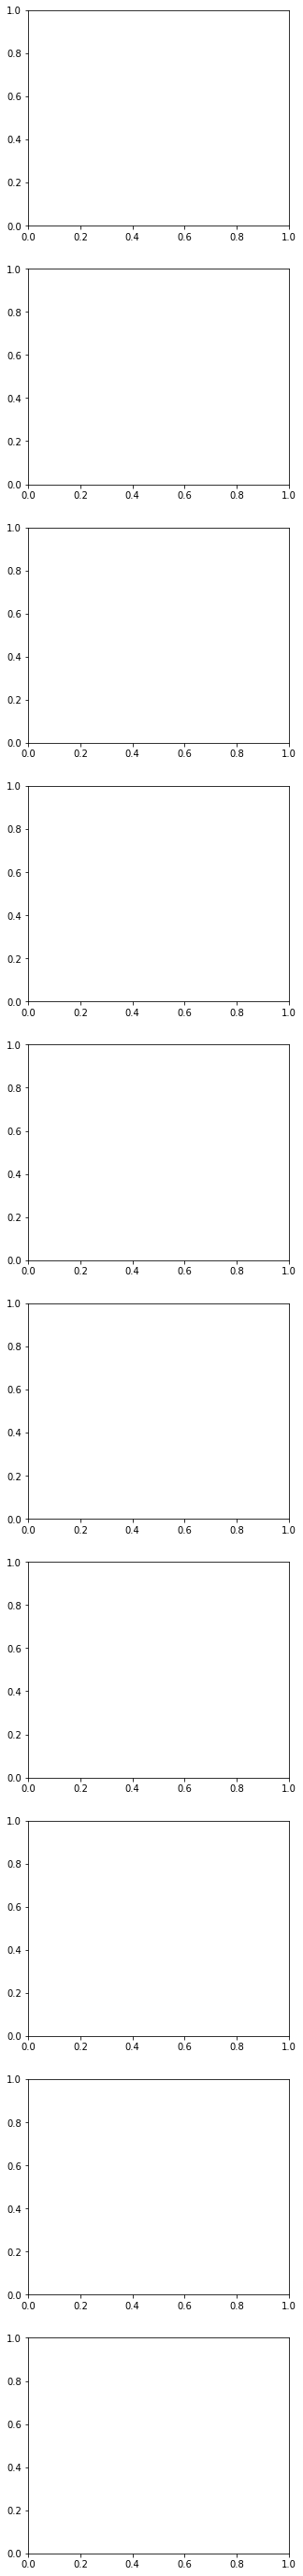

In [7]:
fig, ax = plt.subplots(10, 1, figsize=(5, 50))
plt.show()